# Quantum Annealer for Philogenetic Trees

---

In this notebook, we are going to use D-Wave's Ocean to create the needed optimization problem to reconstruct Philogenetic Trees. In short, this is where the real work begins. This work will be based in 2 documents, a book that describes Quantum Annealing [1], and the paper for reconstruction of Philogenetic Trees [2].



[1] Combarro, E. F., & Gonzalez-Castillo, S. (2023). A practical guide to quantum machine learning and quantum optimisation: Hands-On Approach to Modern Quantum Algorithms. Packt Publishing.

[2] Onodera, W., Hara, N., Aoki, S., Asahi, T., & Sawamura, N. (2022). Phylogenetic tree reconstruction via graph cut presented using a quantum-inspired computer. Molecular Phylogenetics and Evolution, 178, 107636. https://doi.org/10.1016/j.ympev.2022.107636

In [2]:
import numpy as np
import dimod
from dimod import BinaryQuadraticModel, BINARY
from typing import Optional
from dwave.system import DWaveSampler, EmbeddingComposite
from colorama import Fore
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

First, we start with an example:

In [3]:
# Coefficients of the quadratic term elements (squared or products)
J = {(0,1):1, (0,2):1}
# Coefficients of the linear terms
h = {}
problem = BinaryQuadraticModel(h, J, 0.0, BINARY)
print("The problem we are going to solve is:")
print(problem)

The problem we are going to solve is:
BinaryQuadraticModel({0: 0.0, 1: 0.0, 2: 0.0}, {(1, 0): 1.0, (2, 0): 1.0}, 0.0, 'BINARY')


From the paper we have that the minimization is defined as:

$$Min_{cut}=\sum_{i=1}^{n-1}\sum_{j=i+1}^n d_{ij}(x_i-x_j)^2,\qquad x_i=\{0,1\}, \quad i = 1,...,n.$$

Where $d_{ij}$ is the element $ij$ from the matrix $D$, where the differences between elements are represented. In other words, if you consider the problem as a graph, $D$ is the adjacency matrix from the graph.

If we take a closer look at this formula, we can see that we take the top part of the matrix, also, we start counting from 1, and I don't want that, so we can rewrite the expression as:

$$Min_{cut}=\sum_{i=0}^{n-2}\sum_{j=i+1}^{n-1} d_{ij}(x_i-x_j)^2,\qquad x_i=\{0,1\}, \quad i = 0,...,n-1.$$

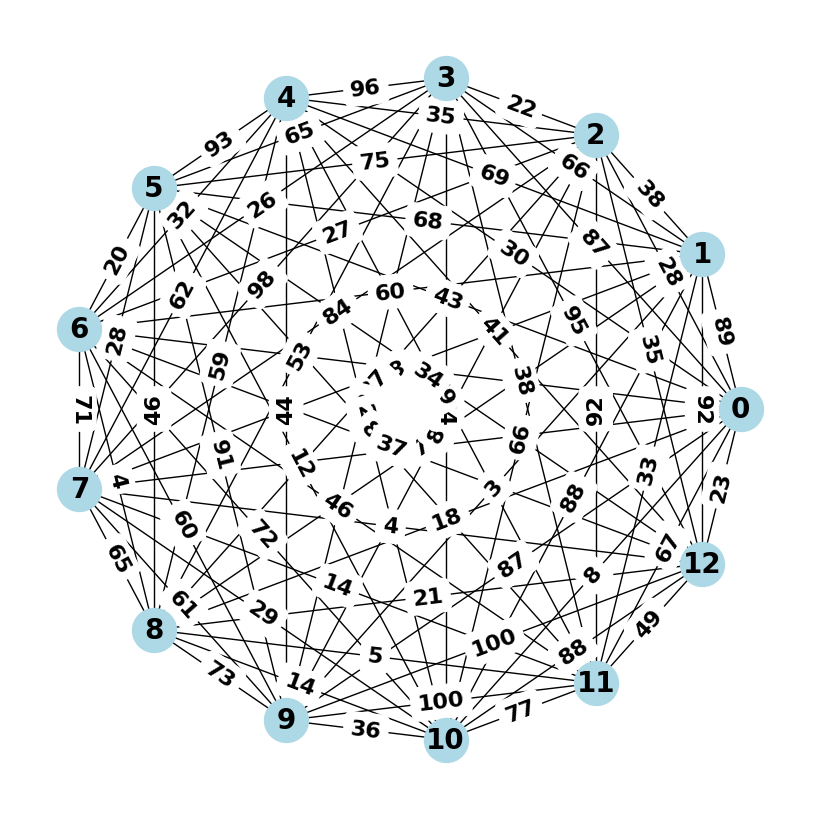

In [87]:
# Create a complete graph with n nodes
G = nx.complete_graph(13)

# Assign random weights normalized between 0 and 100
for u, v in G.edges():
    G[u][v]['weight'] = random.randint(0, 100)

# Positions for a circular layout
pos = nx.circular_layout(G)

# Draw the graph
plt.figure(figsize=(8, 8))
nx.draw(
    G, pos, with_labels=True, node_color='lightblue', 
    node_size=1000, font_size=20, font_weight='bold'
)

# Draw edge labels with weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=edge_labels, font_color='black', font_size=16, font_weight='bold'
)

plt.show()

To start, as I don't have any data to create adjacency matrices, I can create a random all-to-all graph with the characteristics defined in the paper. The graph would be the next:

<div style="text-align: center;">
    <img src="./images/randgraph_5.png" alt="Complete Graph" width="600px">
</div>

Defined by the following adjacency matrix:

$$
\begin{pmatrix}
    0  & 92 & 73 & 78 & 92 \\
    92 & 0  & 21 & 49 & 34 \\
    73 & 21 & 0  & 35 & 63 \\
    78 & 49 & 35 & 0  & 29 \\
    92 & 34 & 63 & 29 & 0 \\
\end{pmatrix}
$$

Firstly, we can create a function that creates ``BinaryQuadraticModel`` objects from a given matrix for our problem. This will facilitate the process hereafter.

In [20]:
# Function to create BinaryQuadraticModel from a numpy matrix
def create_problem (matrix:np.ndarray)->BinaryQuadraticModel:
    r"""
    Creates a BinaryQuadraticModel from a numpy matrix using the Min-cut formulation. Both simmetrical matrices and matrices with 0 above the main diagonal work.
    
    Args:
        `matrix`: Matrix that defines the problem.
    
    Returns:
        The BinaryQuadraticModel from dimod that defines the problem.
    """
    
    rows = matrix.shape[0]
    var = []
    
    for i in range(rows):
        var.append(dimod.Binary('x'+str(i)))
        
    obj = BinaryQuadraticModel({},{},0.0,BINARY)
    
    for i in range(rows):
        for j in range(i):
            obj+=matrix[i,j]*(var[i]-var[j])**2
            
    return obj

In [21]:
matrix = np.array([[0,0,0,0,0],[92,0,0,0,0],[73,21,0,0,0],[78,49,35,0,0],[92,34,63,29,0]])

problem = create_problem(matrix)
print(problem)

BinaryQuadraticModel({'x1': 196.0, 'x0': 335.0, 'x2': 192.0, 'x3': 191.0, 'x4': 218.0}, {('x0', 'x1'): -184.0, ('x2', 'x1'): -42.0, ('x2', 'x0'): -146.0, ('x3', 'x1'): -98.0, ('x3', 'x0'): -156.0, ('x3', 'x2'): -70.0, ('x4', 'x1'): -68.0, ('x4', 'x0'): -184.0, ('x4', 'x2'): -126.0, ('x4', 'x3'): -58.0}, 0.0, 'BINARY')


It's important to know that the next cell access the D-Wave Quantum Annealer. That's why there's commented lines.

In [ ]:
# You need to have an access token configured
# sampler = EmbeddingComposite(DWaveSampler())
# result = sampler.sample(problem, num_reads=10)
print("The solutions that we have obtained are")
print(result)

The solutions that we have obtained are
   0  1  2  3  4 energy num_oc. chain_.
0  0  0  0  0  0    0.0       5     0.0
1  1  1  1  1  1    0.0       5     0.0
['BINARY', 2 rows, 10 samples, 5 variables]


In [55]:
print(f'Time required to complete: {result.info['timing']['qpu_access_time']}ms')

Time required to complete: 16541.56ms


In [45]:
x0 = dimod.Binary('x0')
x1 = dimod.Binary('x1')
x2 = dimod.Binary('x2')

blp = dimod.ConstrainedQuadraticModel()

blp.set_objective(3*(x0-x1)**2+3*(x1-x2)**2+(x0-x2)**2+24*(x0+x1+x2-1)**2)
# blp.add_constraint(x0+x1+x2 == 1 )
# blp.add_constraint(x0+x1+x2 <= 2 )

print(blp)

solver = dimod.ExactCQMSolver()

sol = solver.sample_cqm(blp)

print('Solutions')
print(sol,'\n')

# We want the best feasible solution. We can filter by its feasibility and take the first element
feas_sol = sol.filter(lambda s: s.is_feasible)
print(Fore.RED+'Best Solution'+Fore.RESET)
print(f'Variables: {feas_sol.first.sample}, Cost = {feas_sol.first.energy}')

Constrained quadratic model: 3 variables, 0 constraints, 6 biases

Objective
  24 - 20*Binary('x0') - 18*Binary('x1') - 20*Binary('x2') + 42*Binary('x0')*Binary('x1') + 46*Binary('x0')*Binary('x2') + 42*Binary('x1')*Binary('x2')

Constraints

Bounds

Solutions
  x0 x1 x2 energy num_oc. is_sat. is_fea.
2  1  0  0    4.0       1 arra... np.T...
4  0  0  1    4.0       1 arra... np.T...
1  0  1  0    6.0       1 arra... np.T...
0  0  0  0   24.0       1 arra... np.T...
3  1  1  0   28.0       1 arra... np.T...
5  0  1  1   28.0       1 arra... np.T...
6  1  0  1   30.0       1 arra... np.T...
7  1  1  1   96.0       1 arra... np.T...
['INTEGER', 8 rows, 8 samples, 3 variables] 

Best Solution
Variables: {'x0': np.int64(1), 'x1': np.int64(0), 'x2': np.int64(0)}, Cost = 4.0


In [144]:
qubo = dimod.cqm_to_bqm(blp,lagrange_multiplier=5)
print(qubo)

(BinaryQuadraticModel({'x0': 3.0, 'x1': 5.0, 'x2': 3.0}, {('x1', 'x0'): -4.0, ('x2', 'x0'): 0.0, ('x2', 'x1'): -4.0}, 1.0, 'BINARY'), <dimod.constrained.constrained.CQMToBQMInverter object at 0x000002089A377640>)


In [3]:
# Function to create BinaryQuadraticModel from a numpy matrix
def create_cqm_problem (matrix:np.ndarray,tags=[],c=0,alpha=0)->dimod.ConstrainedQuadraticModel:
    r"""
    Creates a ConstrainedQuadraticModel from a numpy matrix using the Min-cut formulation. Both simmetrical matrices and matrices with 0 above the main diagonal work.
    
    Args:
        `matrix`: Matrix that defines the problem.
        `tags`: Name for the variables. Used in the Philogenetic Tree to mantain tags for each matrix.
        `c`: Number of non zero results wanted.
        `alpha`: Factor to amplify. Higher alpha (>1) achieve the number of `c` of non zero results easily. If 0, no defined `c` is set, thus 11...11 and 00...00 become the best solution.
    
    Returns:
        The ConstrainedQuadraticModel from dimod that defines the problem.
    """
    
    rows = matrix.shape[0]
    var = []
    
    if not tags:
        for i in range(rows):
            var.append(dimod.Binary(i))
    else:
        var = [dimod.Binary(i) for i in tags]
        
    obj = BinaryQuadraticModel({},{},0.0,BINARY)
    
    for i in range(rows):
        for j in range(i):
            obj+=matrix[i,j]*(var[i]-var[j])**2
    
    suma = np.sum(var)      
    # Add restriction term
    obj+=alpha*(suma-c)**2
    
    problem = dimod.ConstrainedQuadraticModel()
    
    problem.set_objective(obj)
    
    return problem

In [28]:
matrix = np.array([[0,0,0,0,0],[92,0,0,0,0],[73,21,0,0,0],[78,49,35,0,0],[92,34,63,29,0]])

problem = create_cqm_problem(matrix,c=2,alpha=100)

sol = solver.sample_cqm(problem)

print(problem)

print('Solutions')
print(sol,'\n')

# We want the best feasible solution. We can filter by its feasibility and take the first element
feas_sol = sol.filter(lambda s: s.is_feasible)
print(Fore.RED+'Best Solution'+Fore.RESET)
print(f'Variables: {feas_sol.first.sample}, Cost = {feas_sol.first.energy}')

NameError: name 'solver' is not defined

In [40]:
qprob = dimod.cqm_to_bqm(problem)

print(qprob)

(BinaryQuadraticModel({'x1': 196.0, 'x0': 335.0, 'x2': 192.0, 'x3': 191.0, 'x4': 218.0}, {('x0', 'x1'): -184.0, ('x2', 'x1'): -42.0, ('x2', 'x0'): -146.0, ('x3', 'x1'): -98.0, ('x3', 'x0'): -156.0, ('x3', 'x2'): -70.0, ('x4', 'x1'): -68.0, ('x4', 'x0'): -184.0, ('x4', 'x2'): -126.0, ('x4', 'x3'): -58.0}, 0.0, 'BINARY'), <dimod.constrained.constrained.CQMToBQMInverter object at 0x00000233FF201570>)


After this tests, we see that with a high enough $\alpha$ we can guarantee that the best solution contais the subdivision that we want. Knowing this, with good management of the variables we can achieve a solution without adding consraints. Thus, we will refrain from using constraints and use directly the `BinaryQuadraticModel`. However, we will mantain the function `create_cqm_problem` for future convenience of obtaining all solutions in a simple way.

In the next cell, there will be the final problem creation function, so **refrain from using the function from cell 8**.

In [4]:
def min_cut_c (matrix:np.ndarray,tags=[],c=0,alpha=0)->BinaryQuadraticModel:
    r"""
    Creates a BinaryQuadraticModel from a numpy matrix using the Min-cut formulation. Both simmetrical matrices and matrices with 0 above the main diagonal work.
    
    Args:
        `matrix`: Matrix that defines the problem.
        `c`: Number of non zero results desired.
        `alpha`: Factor to amplify. Higher alpha (>1) achieve the number of `c` of non zero results easily. If 0, no defined `c` is set, thus 11...11 and 00...00 become the best solution.
    
    Returns:
        The BinaryQuadraticModel from dimod that defines the problem.
    """
    
    rows = matrix.shape[0]
    var = []
    
    if not tags:
        for i in range(rows):
            var.append(dimod.Binary(i))
    else:
        var = [dimod.Binary(i) for i in tags]
    obj = BinaryQuadraticModel({},{},0.0,BINARY)
    
    for i in range(rows):
        for j in range(i):
            obj+=matrix[i,j]*(var[i]-var[j])**2
    
    suma = np.sum(var)      
    # Add restriction term
    obj+=alpha*(suma-c)**2
    
    return obj

In [ ]:
# Test the code using D-Wave QA
matrix = np.array([[0,0,0,0,0],[92,0,0,0,0],[73,21,0,0,0],[78,49,35,0,0],[92,34,63,29,0]])

problem = min_cut_c(matrix,c=2,alpha=200)

print(problem)

sampler = EmbeddingComposite(DWaveSampler())
result = sampler.sample(problem, num_reads=10)
print("The solutions that we have obtained are")
print(result)

BinaryQuadraticModel({'x3': -404.0, 'x4': -265.0, 'x2': -408.0, 'x1': -409.0, 'x0': -382.0}, {('x4', 'x3'): 216.0, ('x2', 'x3'): 358.0, ('x2', 'x4'): 254.0, ('x1', 'x3'): 302.0, ('x1', 'x4'): 244.0, ('x1', 'x2'): 330.0, ('x0', 'x3'): 332.0, ('x0', 'x4'): 216.0, ('x0', 'x2'): 274.0, ('x0', 'x1'): 342.0}, 800.0, 'BINARY')
The solutions that we have obtained are
  x0 x1 x2 x3 x4 energy num_oc. chain_.
0  1  0  1  0  0  284.0       4     0.0
1  0  1  0  1  0  289.0       3     0.0
2  0  1  1  0  0  313.0       1     0.0
3  0  0  0  1  1  347.0       1     0.0
4  1  1  0  0  0  351.0       1     0.0
['BINARY', 5 rows, 10 samples, 5 variables]


In [24]:
print(f'Time required to complete: {result.info['timing']['qpu_access_time']}us')
print(f'Best solution energy: {result.first.energy}')
print(f'Best solution configuration: {result.first.sample}')

n_graph_0 = [i for i in result.first.sample if result.first.sample[i]==0]
n_graph_1 = [i for i in result.first.sample if result.first.sample[i]==1]

print(f'The cut graph are:\nGraph 1: {n_graph_0}\nGraph 2: {n_graph_1}')

Time required to complete: 16765.56us
Best solution energy: 284.0
Best solution configuration: {'x0': np.int8(1), 'x1': np.int8(0), 'x2': np.int8(1), 'x3': np.int8(0), 'x4': np.int8(0)}
The cut graph are:
Graph 1: ['x1', 'x3', 'x4']
Graph 2: ['x0', 'x2']


In [34]:
indices = [int(i[1]) for i in n_graph_0]
indices2 = [int(i[1]) for i in n_graph_1]

new_matrix = matrix[np.ix_(indices, indices)]

print(new_matrix)


[[ 0  0  0]
 [49  0  0]
 [34 29  0]]


In [17]:
def n_cut(score,ng0,ng1,og):
    r"""
    Returns the Ncut from a cut.
    
    Args:
        `score`: The energy level obtained from the Mincut method.
        `ng0`: The nodes defining one of the new graphs.
        `ng1`: The nodes defining the other new graph.
        `og`: The original matrix.
    Returns:
        Ncut energy level.
    """
    asoc0 = np.sum(og[ng0, :])
    asoc1 = np.sum(og[ng1, :])   
    
    # print(f'asoc0= {asoc0}, asoc1 = {asoc1}') 
    
    if asoc0 <10e-8 or asoc1 <10e-8:
        ncut = np.inf
    else:
        ncut = (score/asoc0) + (score/asoc1)
    
    return ncut

In [35]:
n_cut(result.first.energy,indices,indices2,matrix)

np.float64(3.6229715109989185)

After this, we can define the full algorithm, without the initial matrix definition.

In [10]:
# Class to create a tree
class TreeNode:
    def __init__(self, value):
        self.value = value
        self.children = []  # A list of child nodes

class Timer:
    def __init__(self,value=0.0) -> None:
        self.value = value
    
    def __str__(self) -> str:
        return f"{self.value}"
    
    def update(self,value):
        self.value += value

In [35]:
def philo_tree(matrix:np.ndarray,tags=[],**kwargs):
    r"""
    Recursive function that uses D-Wave QA to create the tree using Ncut
    
    Args:
        `matrix`: The matrix defining the graph.
        `tags`: Tags defining the names of the nodes, used for recursivity, but you can also name the original 5 nodes. **MUST BE AN INT**
        Probably you could define alpha from outside.
    """
    
    
    ncuts = []
    n_graph_0 = []
    n_graph_1 = []
    sampler = EmbeddingComposite(DWaveSampler())
    
    if not tags:
        sub_mat = matrix
    else:
        sub_mat = matrix[np.ix_(tags, tags)]
        
    rows = sub_mat.shape[0]
    
    var = int(np.floor(rows/2.0))+1

    # Run min_cut for each configuration
    for i in range(1,var):
        # print(f'Corte con {i}')
        if not tags:
            problem = min_cut_c(sub_mat,c=i,alpha=500)
        else:
            problem = min_cut_c(sub_mat,tags=tags,c=i,alpha=500)
        result = sampler.sample(problem, num_reads=20)
        
        # Time measurement
        if 'timer' in kwargs:
            kwargs['timer'].update(result.info['timing']['qpu_access_time']/1000)
            
        n_graph_0.append([j for j in result.first.sample if result.first.sample[j]==0])
        n_graph_1.append([j for j in result.first.sample if result.first.sample[j]==1])        
        # print(f'\tLa division es: {n_graph_0[i-1]} | {n_graph_1[i-1]}')
        
        if not n_graph_0[i-1] or not n_graph_1[i-1]:
            n_graph_0.pop()
            n_graph_1.pop()
        else:
            ncuts.append(n_cut(result.first.energy,n_graph_0[i-1],n_graph_1[i-1],matrix))
        
    
    # Get the cuts created by the minimum ncut value
    index = np.argmin(ncuts)
    # print(f'Se selecciona la separacion: {n_graph_0[index]} | {n_graph_1[index]}')
    
    node = TreeNode(tags)
    
    # Recursivity in the first graph
    if len(n_graph_0[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(philo_tree(matrix,n_graph_0[index],timer=kwargs['timer']))
        else:
            node.children.append(philo_tree(matrix,n_graph_0[index]))
    else:
        leaf = TreeNode(n_graph_0[index])
        if len(n_graph_0[index]) == 2:
            leaf.children.append(TreeNode([n_graph_0[index][0]]))
            leaf.children.append(TreeNode([n_graph_0[index][1]]))
        node.children.append(leaf)
        
    # Recursivity in the first graph
    if len(n_graph_1[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(philo_tree(matrix,n_graph_1[index],timer=kwargs['timer']))
        else:
            node.children.append(philo_tree(matrix,n_graph_1[index]))
    else:
        leaf = TreeNode(n_graph_1[index])
        if len(n_graph_1[index]) == 2:
            leaf.children.append(TreeNode([n_graph_1[index][0]]))
            leaf.children.append(TreeNode([n_graph_1[index][1]]))
        node.children.append(leaf)
    
    return node

In [11]:
def print_tree(node:TreeNode, prefix="", is_last=True):
    """
    Prints the tree structure with a visually appealing layout.

    Args:
        node (TreeNode): The current node to print.
        prefix (str): The prefix for the current node (e.g., spaces and vertical bars).
        is_last (bool): True if the node is the last child of its parent.
    """
    if node is None:
        return

    # Prettier connectors
    connector = "└── " if is_last else "├── "
    if len(node.value)!=1:
        print(prefix + connector + '|')
    else:
        print(prefix + connector + str(node.value))

    # Update the prefix for child nodes
    if node.children:
        for i, child in enumerate(node.children):
            # Use "│   " for intermediate children, "    " for the last child
            next_prefix = prefix + ("    " if is_last else "│   ")
            print_tree(child, next_prefix, i == len(node.children) - 1)


In [ ]:
matrix = np.array([[0,0,0,0,0],[92,0,0,0,0],[73,21,0,0,0],[78,49,35,0,0],[92,34,63,29,0]])
tree = philo_tree(matrix)
print('El arbol resultante es: \n\n')
print_tree(tree)

El arbol resultante es: 


└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── [0]
    │   │   │   └── [4]
    │   │   └── [2]
    │   └── [1]
    └── [3]


TypeError: unhashable type: 'list'

We have created a tree. However, this tree always takes the cut with one value. To see if this is a norm or an exception, We can try other graphs, for example:

<div style="text-align: center;">
    <img src="./images/randgraph_7.png" alt="Complete Graph" width="600px">
</div>

In [122]:
timer = Timer(0.0)
tree = philo_tree(matrix,timer=timer)
print('The resulting tree is: \n\n')
print_tree(tree)
print(f'The time used to compute the solutions is: {timer}ms')

The resulting tree is: 


└── |
    ├── |
    │   ├── |
    │   │   ├── [4]
    │   │   └── [6]
    │   └── |
    │       ├── [2]
    │       └── [3]
    └── |
        ├── |
        │   ├── [1]
        │   └── [5]
        └── [0]
The time used to compute the solutions is: 50.491879999999995ms


In [15]:
# Matrix to text, because of the randomness. This is the Matrix that defines the graph from './images/randgraph_7.png'
matrix = np.array([[ 0., 30., 17., 73., 33., 51.,  9.],
       [30.,  0., 32., 99., 63., 99., 48.],
       [17., 32.,  0., 80., 23.,  4.,  5.],
       [73., 99., 80.,  0., 89., 13., 95.],
       [33., 63., 23., 89.,  0., 68., 86.],
       [51., 99.,  4., 13., 68.,  0., 15.],
       [ 9., 48.,  5., 95., 86., 15.,  0.]])

It was a fluke, the program creates well distributed graphs. But, are they correct? To test this, we will make use of our function that creates a Mincut problem as a CQM and use a brute force solver. We will input this in the Ncut method to obtain the tree.

In [12]:
def bf_tree(matrix,tags=[],**kwargs):
    
    ncuts = []
    n_graph_0 = []
    n_graph_1 = []
    solver = dimod.ExactCQMSolver()
    
    if not tags:
        sub_mat = matrix
    else:
        sub_mat = matrix[np.ix_(tags, tags)]
        
    rows = sub_mat.shape[0]
    
    var = int(np.floor(rows/2.0))+1

    # Run min_cut for each configuration
    for i in range(1,var):
        # print(f'Corte con {i}')
        if 'timer' in kwargs:
            start = time.time_ns()/1000000
            
        if not tags:
            problem = create_cqm_problem(sub_mat,c=i,alpha=500)
        else:
            problem = create_cqm_problem(sub_mat,tags=tags,c=i,alpha=500)

        sol = solver.sample_cqm(problem)

        # We want the best feasible solution. We can filter by its feasibility and take the first element
        feas_sol = sol.filter(lambda s: s.is_feasible)
        
        if 'timer' in kwargs:
            end = time.time_ns()/1000000
            kwargs['timer'].update(end-start)
            
        n_graph_0.append([j for j in feas_sol.first.sample if feas_sol.first.sample[j]==0])
        n_graph_1.append([j for j in feas_sol.first.sample if feas_sol.first.sample[j]==1])   
        # print(f'\tLa division es: {n_graph_0[i-1]} | {n_graph_1[i-1]}')
        
        if not n_graph_0[i-1] or not n_graph_1[i-1]:
            n_graph_0.pop()
            n_graph_1.pop()
        else:
            ncuts.append(n_cut(feas_sol.first.energy,n_graph_0[i-1],n_graph_1[i-1],matrix))
    
    index = np.argmin(ncuts)
    # print(f'Se selecciona la separacion: {n_graph_0[index]} | {n_graph_1[index]}')
    
    node = TreeNode(tags)
    
    # Recursivity in the first graph
    if len(n_graph_0[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(bf_tree(matrix,n_graph_0[index],timer=kwargs['timer']))
        else:
            node.children.append(bf_tree(matrix,n_graph_0[index]))
    else:
        leaf = TreeNode(n_graph_0[index])
        if len(n_graph_0[index]) == 2:
            leaf.children.append(TreeNode([n_graph_0[index][0]]))
            leaf.children.append(TreeNode([n_graph_0[index][1]]))
        node.children.append(leaf)
        
    # Recursivity in the first graph
    if len(n_graph_1[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(bf_tree(matrix,n_graph_1[index],timer=kwargs['timer']))
        else:
            node.children.append(bf_tree(matrix,n_graph_1[index]))
    else:
        leaf = TreeNode(n_graph_1[index])
        if len(n_graph_1[index]) == 2:
            leaf.children.append(TreeNode([n_graph_1[index][0]]))
            leaf.children.append(TreeNode([n_graph_1[index][1]]))
        node.children.append(leaf)
    
    return node

In [13]:
# More visual way
# Recursive function to calculate positions for nodes
def calculate_positions(node, x=0, y=0, dx=1,dy=0.5, positions=None, parent_positions=None, parent=None):
    if positions is None:
        positions = {}
    if parent_positions is None:
        parent_positions = []

    # Assign a position to the current node
    node_label = str(node.value)  # Convert list to string for display
    positions[node_label] = (x, y)
    if parent is not None:
        parent_positions.append((parent, node_label))

    # Layout children
    num_children = len(node.children)
    if num_children > 0:
        child_dx = dx / num_children
        child_x = x - dx / 2 + child_dx / 2
        for child in node.children:
            calculate_positions(child, child_x, y - dy, child_dx, dy, positions, parent_positions, node_label)
            child_x += child_dx

    return positions, parent_positions

def display_tree(positions,parent_positions,tree_size=1,square=True):
    plt.figure(figsize=(10*tree_size, 5*tree_size))
    
    if not square:
        for parent, child in parent_positions:
            x1, y1 = positions[parent]
            x2, y2 = positions[child]
            plt.plot([x1, x2], [y1, y2], "k-")  # Draw edges
    
    if square:
    # Draw edges with straight lines
        for parent, child in parent_positions:
            x1, y1 = positions[parent]
            x2, y2 = positions[child]

            # Horizontal line to connect parent to the child's vertical position
            plt.plot([x1, x2], [y1, y1], "k-")
            # Vertical line to connect child's position to the horizontal line
            plt.plot([x2, x2], [y1, y2], "k-")

    # Display nodes with single-element values
    for node, (x, y) in positions.items():
        
        if len(eval(node)) == 1:  # Check the list length
            plt.scatter(x, y, s=500, color="lightblue",edgecolors='black')
            if len(node) == 4:
                plt.text(x, y, node[1:-1], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.3'))
            else:
                plt.text(x, y, node[1:-1], ha="center", weight='bold', va="center", fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="none",boxstyle='circle,pad=0.5'))

    plt.axis("off")
    plt.title("Philogenetic tree")
    plt.show()  

El arbol resultante es: 


└── |
    ├── |
    │   ├── |
    │   │   ├── [4]
    │   │   └── [6]
    │   └── |
    │       ├── [2]
    │       └── [3]
    └── |
        ├── |
        │   ├── [1]
        │   └── [5]
        └── [0]
The time used to compute the solutions is: 19.954833984375ms


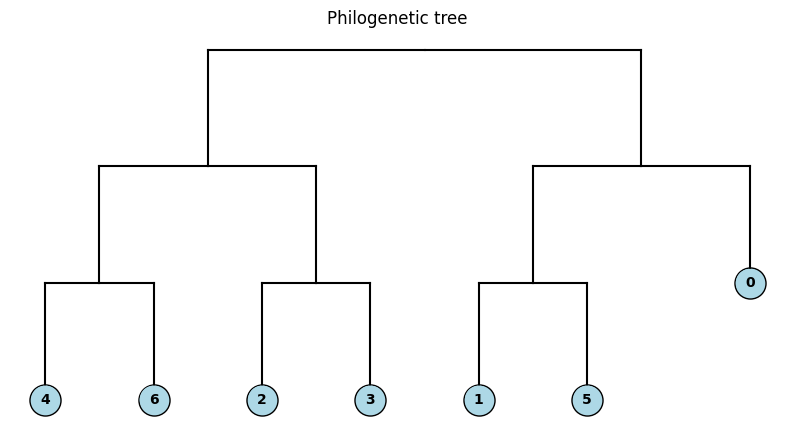

In [19]:
timer = Timer(0.0)
tree = bf_tree(matrix,timer=timer)
print('El arbol resultante es: \n\n')
print_tree(tree)
print(f'The time used to compute the solutions is: {timer}ms')

pos, par_pos = calculate_positions(tree)
display_tree(pos, par_pos)

YEAH. We get the same solution using a exact method. As a matter of fact, it may be faster, when removing the connections to D-Wave's Quantum Annealer. However, we can not test that...

<span style="font-weight: bold; color: #39ff14; font-size: larger;">SIKE</span>. We can do it although it could require a bit of tweaking of out functions. We only need the time used by the quantum annealer (that we can get), and the time to obtain and filter the results using brute force. That is the difference between methods, as everything else in the function works exactly the same. To solve this problem, we will use a new object (that is a encapsulated float) in both functions, that saves the time.

<span style="font-weight: bold; color: #FF0000; font-size: larger;">NOPE</span>. The QA is slower than a brute force method, at least for small values. That will probably change for bigger graphs.

New graph of 10 nodes:

<div style="text-align: center;">
    <img src="./images/randgraph_10.png" alt="Complete Graph" width="600px">
</div>

In [24]:
# matrix = nx.to_numpy_array(G)

matrix = np.array([[  0.,   4.,  70.,  88.,  30.,  36.,  23.,   5.,  72.,  36.],
       [  4.,   0.,  33.,  89.,   9.,  23.,  18.,   9.,  60.,  79.],
       [ 70.,  33.,   0.,  36.,  15., 100.,   7.,  14.,  10.,  18.],
       [ 88.,  89.,  36.,   0.,   6.,  35.,  69.,  96.,  67.,  15.],
       [ 30.,   9.,  15.,   6.,   0.,  66.,  54.,  45.,  77.,  49.],
       [ 36.,  23., 100.,  35.,  66.,   0.,  93.,   3.,  75.,  84.],
       [ 23.,  18.,   7.,  69.,  54.,  93.,   0.,   2.,  43.,   1.],
       [  5.,   9.,  14.,  96.,  45.,   3.,   2.,   0.,   6.,  86.],
       [ 72.,  60.,  10.,  67.,  77.,  75.,  43.,   6.,   0.,  95.],
       [ 36.,  79.,  18.,  15.,  49.,  84.,   1.,  86.,  95.,   0.]])

#### QA

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── [5]
    │   │   │   └── [6]
    │   │   └── |
    │   │       ├── [4]
    │   │       └── [8]
    │   └── |
    │       ├── |
    │       │   ├── [0]
    │       │   └── [3]
    │       └── [2]
    └── |
        ├── |
        │   ├── [7]
        │   └── [9]
        └── [1]
The time used to compute the solutions is: 202.18652000000003ms


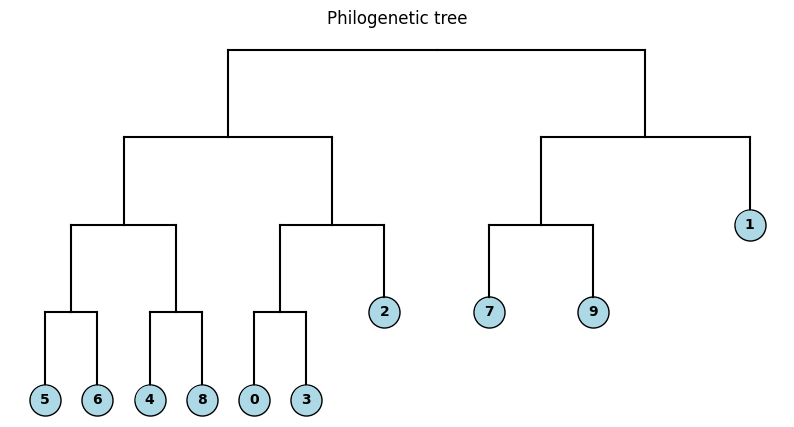

In [25]:
# matrix = nx.to_numpy_array(G)
timer = Timer(0.0)
tree = philo_tree(matrix,timer=timer)
print('The resulting tree is: \n')
print_tree(tree)
print(f'The time used to compute the solutions is: {timer}ms')

pos, par_pos = calculate_positions(tree)
display_tree(pos, par_pos)

#### Brute Force

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── [4]
    │   │   │   └── [8]
    │   │   └── |
    │   │       ├── [5]
    │   │       └── [6]
    │   └── |
    │       ├── [0]
    │       └── [2]
    └── |
        ├── |
        │   ├── [7]
        │   └── [9]
        └── |
            ├── [1]
            └── [3]
The time used to compute the solutions is: 86.733154296875ms


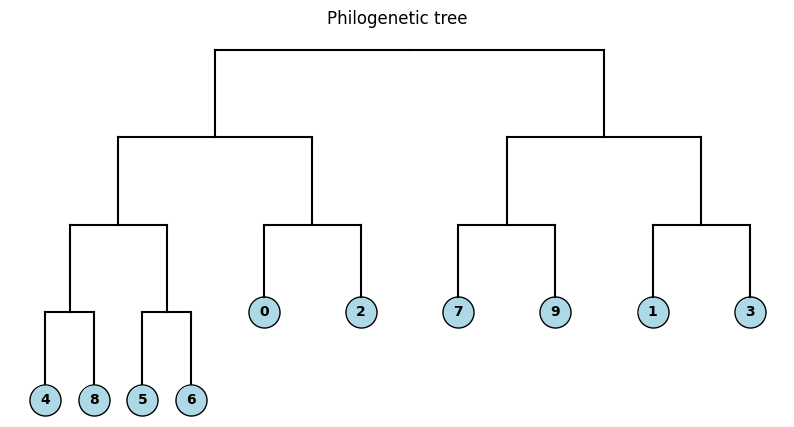

In [26]:
# matrix = nx.to_numpy_array(G)
timer = Timer(0.0)
tree = bf_tree(matrix,timer=timer)
print('The resulting tree is: \n')
print_tree(tree)
print(f'The time used to compute the solutions is: {timer}ms')

pos, par_pos = calculate_positions(tree)
display_tree(pos, par_pos)

New graph of 13 nodes:

<div style="text-align: center;">
    <img src="./images/randgraph_13.png" alt="Complete Graph" width="600px">
</div>

In [29]:
# matrix = nx.to_numpy_array(G)
matrix = np.array([  [ 0.,  89.,  28.,  87.,  30.,  43.,  55.,   4.,  18.,  87.,   8., 67.,  23.],
                    [ 89.,   0.,  38.,  66.,  69.,  68.,  60.,  48.,  74.,   3.,  88., 33.,  92.],
                    [ 28.,  38.,   0.,  22.,  35.,  75.,  27.,  84.,  37.,  86.,  66., 92.,  35.],
                    [ 87.,  66.,  22.,   0.,  96.,  65.,  26.,  98.,  53.,   2.,  44., 38.,  95.],
                    [ 30.,  69.,  35.,  96.,   0.,  93.,  32.,  62.,  59.,  44.,  29., 69.,  41.],
                    [ 43.,  68.,  75.,  65.,  93.,   0.,  20.,  28.,  46.,  91.,  12., 86.,  34.],
                    [ 55.,  60.,  27.,  26.,  32.,  20.,   0.,  71.,   4.,  60.,  72., 46.,  37.],
                    [  4.,  48.,  84.,  98.,  62.,  28.,  71.,   0.,  65.,  61.,  29., 14.,   4.],
                    [ 18.,  74.,  37.,  53.,  59.,  46.,   4.,  65.,   0.,  73.,  14., 5.,  21.],
                    [ 87.,   3.,  86.,   2.,  44.,  91.,  60.,  61.,  73.,   0.,  36., 100., 100.],
                    [  8.,  88.,  66.,  44.,  29.,  12.,  72.,  29.,  14.,  36.,   0., 77.,  88.],
                    [ 67.,  33.,  92.,  38.,  69.,  86.,  46.,  14.,   5., 100.,  77., 0.,  49.],
                    [ 23.,  92.,  35.,  95.,  41.,  34.,  37.,   4.,  21., 100.,  88., 49.,   0.]])

#### Brute Force

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── |
    │   │   │   │   ├── [9]
    │   │   │   │   └── [11]
    │   │   │   └── [2]
    │   │   └── [5]
    │   └── |
    │       ├── |
    │       │   ├── [7]
    │       │   └── [8]
    │       └── [4]
    └── |
        ├── |
        │   ├── |
        │   │   ├── |
        │   │   │   ├── [1]
        │   │   │   └── [12]
        │   │   └── [10]
        │   └── [3]
        └── |
            ├── [0]
            └── [6]
The time used to compute the solutions is: 524.293212890625ms


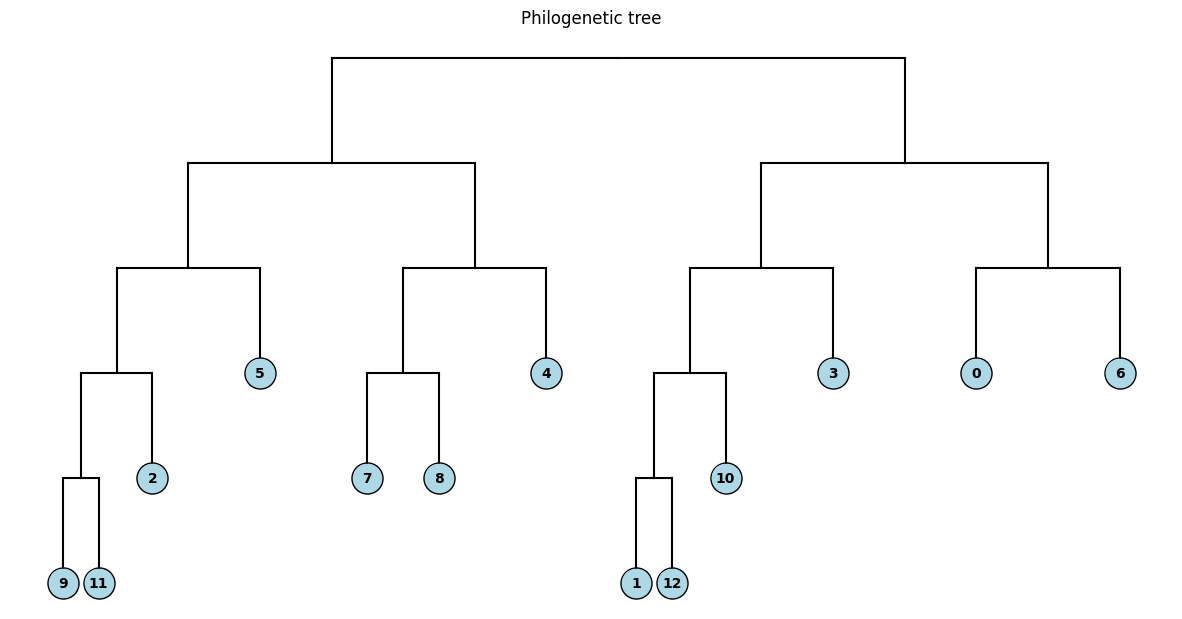

In [31]:
timer = Timer(0.0)
tree = bf_tree(matrix,timer=timer)
print('The resulting tree is: \n')
print_tree(tree)
print(f'The time used to compute the solutions is: {timer}ms')

pos, par_pos = calculate_positions(tree)
display_tree(pos, par_pos,tree_size=1.5)

The resulting tree is: 

└── |
    ├── |
    │   ├── |
    │   │   ├── |
    │   │   │   ├── |
    │   │   │   │   ├── [9]
    │   │   │   │   └── [11]
    │   │   │   └── [2]
    │   │   └── [5]
    │   └── |
    │       ├── |
    │       │   ├── [6]
    │       │   └── [10]
    │       └── [7]
    └── |
        ├── |
        │   ├── |
        │   │   ├── [0]
        │   │   └── [1]
        │   └── [8]
        └── |
            ├── |
            │   ├── [3]
            │   └── [4]
            └── [12]
The time used to compute the solutions is: 318.57568ms


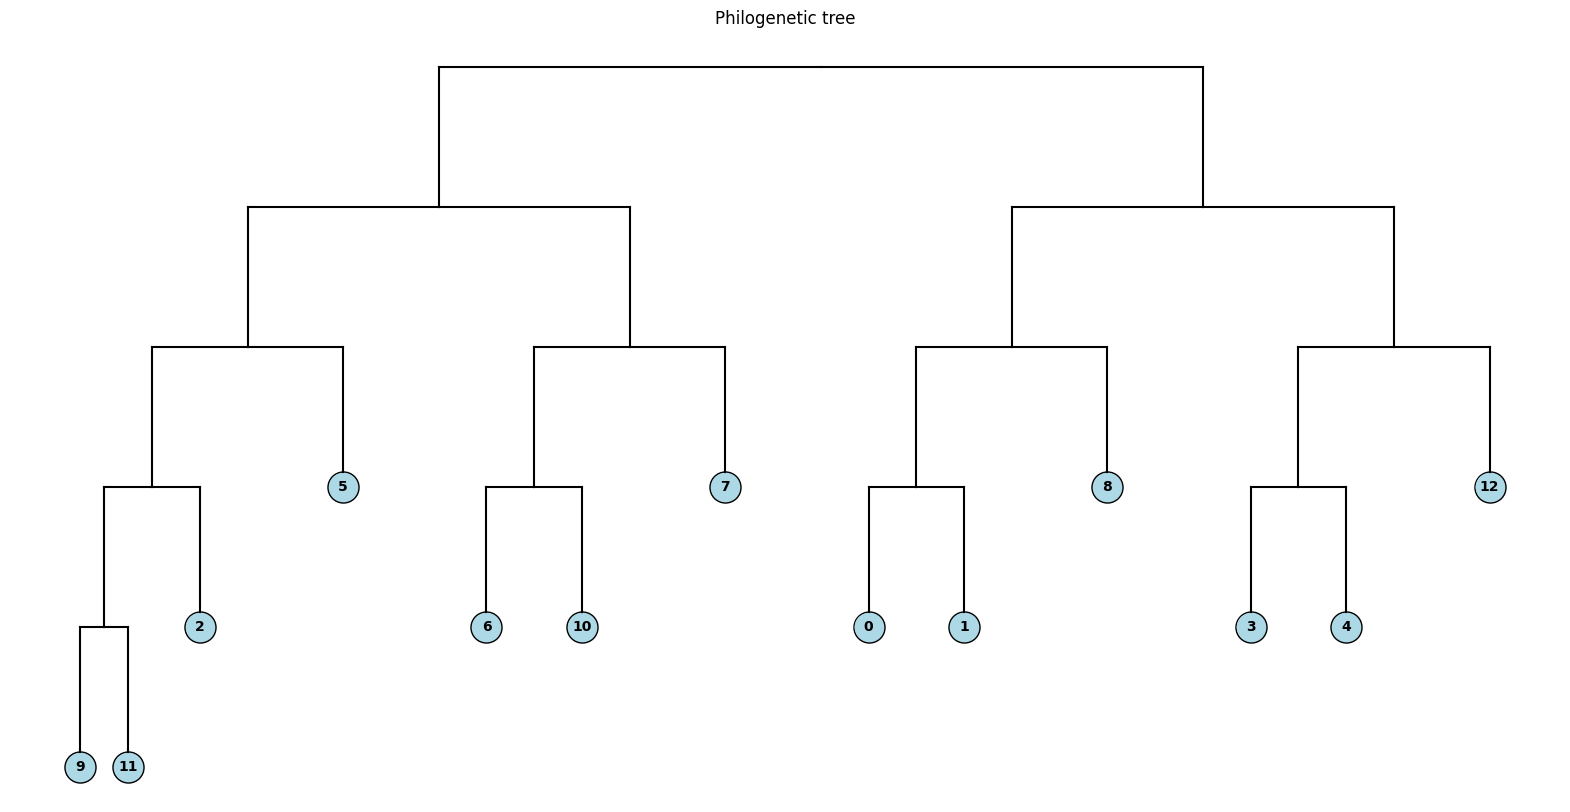

In [38]:
timer = Timer(0.0)
tree = philo_tree(matrix,timer=timer)
print('The resulting tree is: \n')
print_tree(tree)
print(f'The time used to compute the solutions is: {timer}ms')

pos, par_pos = calculate_positions(tree)
display_tree(pos, par_pos,tree_size=2)